In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import cv2
import imutils
import os

### Train

In [2]:
face_recon = cv2.face.FisherFaceRecognizer_create(80)
size = (192, 168)

In [3]:
yale_path = os.path.expanduser('~/Work/Data/CroppedYale')
yale_subjects = os.listdir(yale_path)

train_imgs = []
train_labels = []
for l, d in enumerate(yale_subjects):
    subject_dir = os.path.join(yale_path, d)
    imgs = os.listdir(subject_dir)
    for img in [img for img in imgs if img.endswith('.pgm') and 'Ambient' not in img]:
        full_img = os.path.join(subject_dir, img)
        train_labels.append(l)
        data = cv2.cvtColor(cv2.imread(full_img), cv2.COLOR_BGR2GRAY)
        if data.shape != size:
            raise Exception(data.shape)
        train_imgs.append(data)
    
train_labels = np.array(train_labels)

In [4]:
#face_recon.train(train_imgs, train_labels)

In [5]:
#face_recon.save('yale.yml')

In [6]:
face_recon.read('yale.yml')
print(face_recon.getMean())

[[61.28956089 62.4084507  63.36164043 ... 43.35418393 42.23860812
  41.61723281]]


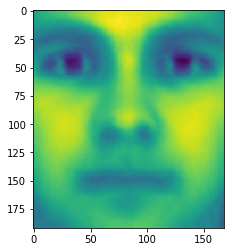

In [7]:
plt.figure()
plt.imshow(np.reshape(face_recon.getMean(), size))

### Detect

In [8]:
img_url = 'https://cdn.theatlantic.com/assets/media/img/mt/2014/03/BhxWutnCEAAtEQ6.jpg_large/lead_720_405.jpg?mod=1533691645'

In [9]:
img = imutils.url_to_image(img_url)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [10]:
face_cascade = cv2.CascadeClassifier('/usr/share/OpenCV/haarcascades/haarcascade_frontalface_alt.xml')

In [11]:
faces = face_cascade.detectMultiScale(img, 1.05, 5)
faces

array([[327,  40,  68,  68],
       [416,   1,  76,  76],
       [ 49,  51, 108, 108],
       [520, 120, 104, 104],
       [238,  35,  85,  85],
       [225, 167, 114, 114],
       [154, 136, 100, 100],
       [341, 170, 162, 162]], dtype=int32)

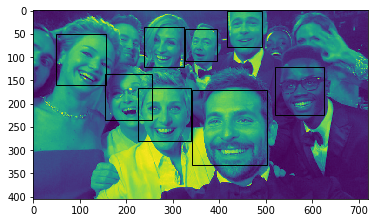

In [12]:
fig, ax = plt.subplots()
ax.imshow(img)
for pos in faces:
    rect = plt.Rectangle((pos[0], pos[1]), pos[2], pos[3], fill=None)
    ax.add_artist(rect)

In [13]:
for pos in faces:
    subimg = img[pos[1]:pos[1]+pos[3],pos[0]:pos[0]+pos[2]]
    resized = cv2.resize(subimg, size)
    print(face_recon.predict(resized))

(4, 455.32558101366385)
(3, 329.71688152609045)
(3, 509.3064472936149)
(29, 334.0765251391805)
(3, 429.44511364850587)
(0, 502.1398203571681)
(35, 675.0582733780047)
(23, 694.1305686409929)


## Matching?

In [14]:
types_dir = os.path.expanduser('~/Work/Data/HumanDetector/Types')

In [15]:
type_names = []
type_imgs = {}
for fname in os.listdir(types_dir):
    full_path = os.path.join(types_dir, fname)
    type_name = os.path.splitext(fname)[0]
    type_names.append(type_name)
    type_imgs[type_name] = cv2.cvtColor(cv2.resize(cv2.imread(full_path, cv2.IMREAD_UNCHANGED), size), cv2.COLOR_BGRA2RGBA)
type_names = np.array(type_names)

In [16]:
# Assign probabilities
nlabels = train_labels.max()
human_prob = 0.6
rest_prob = (1. - human_prob) / (len(type_names) - 1)
type_probs = np.repeat(rest_prob, len(type_names))
type_probs[type_names == 'human'] = human_prob

max_len = max([len(s) for s in type_names])
types = np.array(list(zip(type_names, type_probs)), dtype=[('type', f'U{max_len}'),('prob', 'f')])
types

array([('lizzard', 0.1), ('brainslug', 0.1), ('human', 0.6),
       ('alien', 0.1), ('cybermen', 0.1)],
      dtype=[('type', '<U9'), ('prob', '<f4')])

In [17]:
# To make things easier, use cumulative probs and multiply by nlabels
types['prob'] = np.cumsum(types['prob']) * nlabels
types['prob']

array([ 3.7     ,  7.4     , 29.6     , 33.300003, 37.      ],
      dtype=float32)

In [18]:
type_imgs['human'].shape

(168, 192, 4)

Test with the previous image

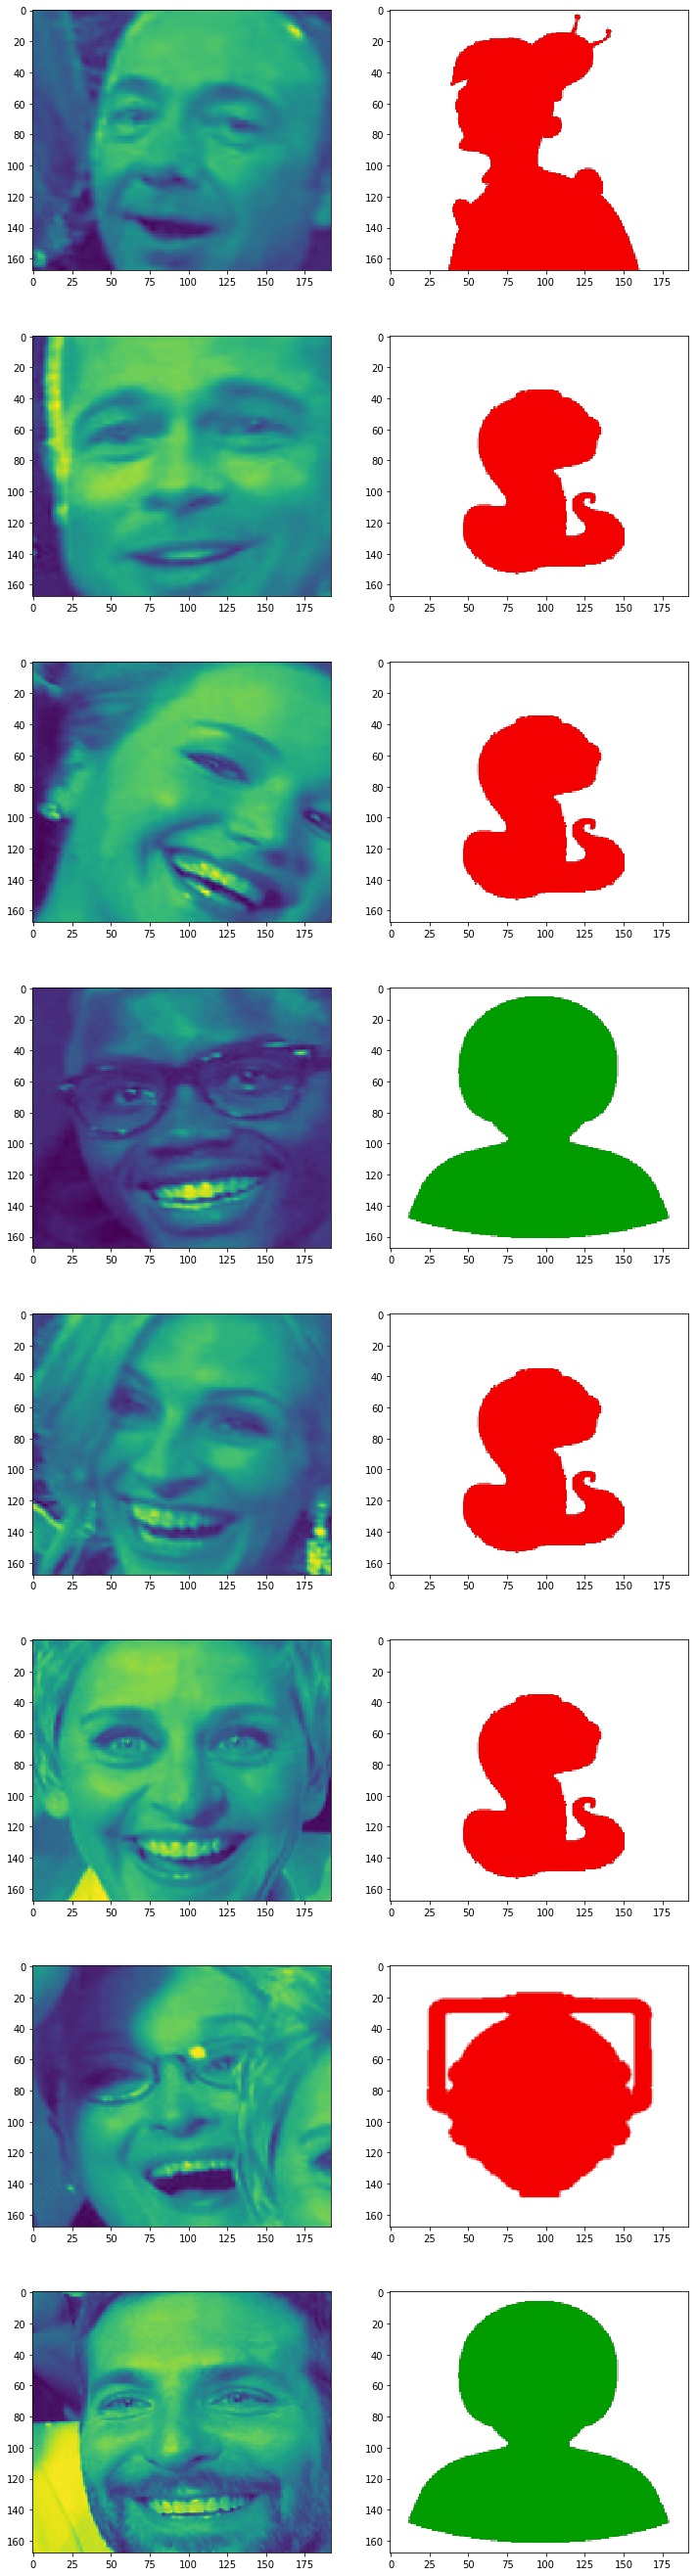

In [19]:
fig, axes = plt.subplots(len(faces), 2, figsize=(12,6*len(faces)))

for i, pos in enumerate(faces):
    subimg = img[pos[1]:pos[1]+pos[3],pos[0]:pos[0]+pos[2]]
    resized = cv2.resize(subimg, size)
    predicted = face_recon.predict(resized)
    less_than = np.where(predicted[0] < types['prob'])
    matching_type = types['type'][less_than[0][0]]
    axes[i,0].imshow(resized)
    axes[i,1].imshow(type_imgs[matching_type])